<a href="https://colab.research.google.com/github/Sofi-240/lipsRead/blob/main/NoteBookipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project - lips reading from a video with Tensorflow and Open-CV**

The model has not yet been trained so there may still be changes in the model layers.

---



# Set up the project libraries



In [ ]:
!pip install opencv-python matplotlib gdown tensorflow
!pip install fuzzywuzzy python-Levenshtein

In [2]:
import os
import cv2
import tensorflow as tf
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import layers, Input
import numpy as np
import random
from matplotlib import pyplot as plt
from fuzzywuzzy import fuzz

# Download the data for the project

1.   The data set - consisting of 1000 videos and text files containing the words spoken respectively [1]
2.   CV2 haarcascade filse for face and mouth detection.



In [ ]:
import gdown
gdown.download(
    'https://drive.google.com/file/d/1yRlZEVFMrOjHHiPUGy3PtnM_foA-P89E/view?usp=sharing',
    'data.zip', quiet=False, fuzzy=True
)
gdown.extractall('/content/data.zip')

# Create the data Pipeline

In [4]:
vocab = list("abcdefghijklmnopqrstuvwxyz'?!123456789 ")
char2num = tf.keras.layers.StringLookup(
    vocabulary=vocab, oov_token=""
)
num2char = tf.keras.layers.StringLookup(
    vocabulary=char2num.get_vocabulary(), oov_token="", invert=True
)


def loadVideo(path):
    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        _, frame = cap.read()
        frame = cv2.cvtColor(
            frame, cv2.COLOR_BGR2RGB
        )
        frames.append(
            tf.convert_to_tensor(
                frame
            )
        )
    cap.release()
    frames = tf.cast(
        frames, tf.float32
    )
    return frames


def loadAlignments(path):
    with open(path, 'r') as f:
        lines = f.readlines()
    words = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            words = [*words, ' ', line[2]]
    words = char2num(
        tf.reshape(
            tf.strings.unicode_split(
                words, input_encoding='UTF-8'
            ), (-1)
        )
    )[1:]
    return words


def loadData(path):
    path = path.numpy().decode('utf-8')
    fileName = path.split('/')[-1].split('.')[0]
    videoPath = os.path.join(
        '/content', 'data', 's1', f'{fileName}.mpg'
    )
    alignmentPath = os.path.join(
        '/content', 'data', 'alignments', 's1', f'{fileName}.align'
    )
    frames = loadVideo(videoPath)
    alignments = loadAlignments(alignmentPath)
    return frames, alignments


def mapData(path):
    ret = tf.py_function(
        loadData, [path], (tf.float32, tf.int64)
    )
    return ret


def createPipeline():
    def map_dir(txt):
        if txt.split('.')[-1] == 'mpg':
            return True
        return False

    files = os.listdir(
        '/content/data/s1/'
    )

    files = list(
        filter(
            map_dir, files
        )
    )

    data = tf.data.Dataset.from_tensor_slices(files)

    data = data.shuffle(
        len(files), reshuffle_each_iteration=False
    )

    data = data.map(
        map_func=mapData
    )

    data = data.padded_batch(
        2, padded_shapes=([75, None, None, 3], [40])
    )

    data = data.prefetch(
        tf.data.AUTOTUNE
    )
    return data


# **Build the Model Layers, Loss function and model Callback with Learning rate schedual and early stoping.**



---



# Preprocessing layer
Perform mouth segmentation on the frames using the Haar cascade classifier from OpenCV. In order to avoid running the segmentation on all frames, the segmentation is performed by calculating the median image from the entire set of frames. Subsequently, validate the segmentation by randomly sampling a few frames from the video and repeating the process.

**Note:**

this process is applicable for videos where the person's movement is relatively limited, enabling the median image to adequately represent the entire sequence.

In [10]:
class PreprocessingLayer(tf.keras.layers.Layer):
    def __init__(self, height, width, **kwargs):
        super(PreprocessingLayer, self).__init__(**kwargs)
        self._out_height = height
        self._out_width = width
        self._out_dim = 1
        self.resize = layers.Resizing(
            height=self._out_height, width=self._out_width,
            interpolation='bicubic', name='resize'
        )
        self.rescale = tf.keras.layers.TimeDistributed(
            layers.Rescaling(
                scale=1. / 255
            ), name='rescale'
        )

    def call(self, x):
        if x.shape[0] is None:
            x = tf.image.rgb_to_grayscale(x)
            x = tf.keras.layers.TimeDistributed(
                self.resize
            )(x)
            return self.rescale(x)

        x = tf.py_function(
            self._mouthSegmentation, [x], x.dtype
        )

        x = self.rescale(x)
        return x

    def _mouthSegmentation(self, frames):
        _type = frames.dtype
        if tf.is_tensor(frames) and frames.shape[0] is not None:
            frames = frames.numpy()
        if frames.shape[0] is None:
            return
        if not isinstance(frames, np.ndarray):
            raise ValueError(
                'frames isinstance need to be tensor or np.ndarray array'
            )

        _init_shape = frames.shape

        if len(_init_shape) < 4:
            raise ValueError(
                'frames shape need to be 4D (without batches) or 5D (with batches)'
            )
        if _init_shape[-1] != 3:
            raise ValueError(
                'frames need to be in RGB format'
            )
        if len(_init_shape) < 5:
            frames = np.expand_dims(
                frames, axis=0
            )

        _init_shape = frames.shape

        bg_crop = []
        face_crop = []
        mouth_crop = np.zeros(
            (*_init_shape[:2], self._out_height, self._out_width, 1)
        )

        frames_median_rgb = np.median(
            frames, axis=1
        )

        for b, image_median in enumerate(frames_median_rgb):
            image_hsv = cv2.cvtColor(
                image_median, cv2.COLOR_RGB2HSV
            )

            threshold, image_bin = cv2.threshold(
                image_hsv[:, :, 0].astype(np.uint8),
                0, 1,
                cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
            )

            kernel = np.ones(
                (5, 5), dtype=np.uint8
            )

            image_bin = cv2.morphologyEx(
                image_bin, cv2.MORPH_OPEN, kernel, iterations=1
            )

            points = cv2.findNonZero(image_bin)
            if points is None:
                bg_crop.append(frames[b])
                continue

            rect = cv2.boundingRect(points)

            crop_frames = tf.image.crop_to_bounding_box(
                frames[b],
                offset_width=rect[0], offset_height=rect[1],
                target_width=rect[2], target_height=rect[3]
            )

            crop_frames = tf.image.rgb_to_grayscale(
                crop_frames
            )

            crop_frames = tf.image.adjust_contrast(
                crop_frames, 1
            ).numpy()

            bg_crop.append(
                crop_frames
            )

        sample_index = random.sample(
            list(
                range(bg_crop[0].shape[0])
            ), 4
        )

        for crop_frames in bg_crop:
            crop_median = np.median(
                crop_frames, axis=0
            ).astype(np.uint8)

            face = faceCascade(crop_median)
            face_prop = [
                face[0][1] - face[0][0],
                face[1][1] - face[1][0]
            ]

            for smpl in sample_index:
                curr_frame = crop_frames[smpl]

                curr_face = faceCascade(curr_frame)
                curr_prop = [
                    curr_face[0][1] - curr_face[0][0],
                    curr_face[1][1] - curr_face[1][0]
                ]
                if (curr_face[0][0] > 0 and curr_face[0][1] < curr_frame.shape[1] - 1 and curr_prop[0] > face_prop[
                    0]) or (
                        face_prop[0] == curr_frame.shape[1] - 1):
                    face[0] = curr_face[0]
                    face_prop[0] = curr_prop[0]

                if (curr_face[1][0] > 0 and curr_face[1][1] < curr_frame.shape[0] - 1 and curr_prop[1] > face_prop[
                    1]) or (
                        face_prop[1] == curr_frame.shape[0] - 1):
                    face[1] = curr_face[1]
                    face_prop[1] = curr_prop[1]

            face_crop.append(
                (
                    crop_frames[:, face[1][0]:face[1][1], face[0][0]:face[0][1], :],
                    crop_median[face[1][0]:face[1][1], face[0][0]:face[0][1], :]
                )
            )

        sample_index = random.sample(
            list(
                range(bg_crop[0].shape[0])
            ), 4
        )

        for b, crop in enumerate(face_crop):
            crop_frames, crop_median = crop
            mouth = mouthCascade(crop_median)
            mouth_prop = [
                mouth[0][1] - mouth[0][0],
                mouth[1][1] - mouth[1][0]
            ]

            for smpl in sample_index:
                curr_frame = crop_frames[smpl]

                curr_mouth = mouthCascade(curr_frame)
                curr_prop = [
                    curr_mouth[0][1] - curr_mouth[0][0],
                    curr_mouth[1][1] - curr_mouth[1][0]
                ]

                if (curr_mouth[0][0] > 0 and curr_mouth[0][1] < curr_frame.shape[1] - 1 and curr_prop[0] > mouth_prop[
                    0]) or (
                        mouth_prop[0] == curr_frame.shape[1] - 1):
                    mouth[0] = curr_mouth[0]
                    mouth_prop[0] = curr_prop[0]

                if (curr_mouth[1][0] > curr_frame.shape[0] // 2 and curr_prop[1] > mouth_prop[1]) or (
                        mouth_prop[1] == (curr_frame.shape[0] // 2) - 1):
                    mouth[1] = curr_mouth[1]
                    mouth_prop[1] = curr_prop[1]

            crop_frames = crop_frames[:, mouth[1][0]:mouth[1][1], mouth[0][0]:mouth[0][1], :]
            mouth_crop[b] = tf.cast(
                self.resize(crop_frames), dtype=_type
            )
        return mouth_crop


def faceCascade(img_gray):
    cascade = cv2.CascadeClassifier(
        "/content/data/haarcascade_frontalface_default.xml"
    )

    rect = cascade.detectMultiScale(
        img_gray.astype(np.uint8)
    )

    if type(rect) == tuple:
        bound = [
            [
                0, img_gray.shape[1] - 1
            ],
            [
                0, img_gray.shape[0] - 1
            ]
        ]
        return bound
    bound = [
        [
            rect[0, 0], min([img_gray.shape[1] - 1, rect[0, 0] + rect[0, 2]])
        ],
        [
            rect[0, 1], min([img_gray.shape[0] - 1, rect[0, 1] + rect[0, 3] + 10])
        ],
    ]
    return bound


def mouthCascade(img_gray):
    cascade = cv2.CascadeClassifier(
        "/content/data/haarcascade_mcs_mouth.xml"
    )

    rect = cascade.detectMultiScale(
        img_gray.astype(np.uint8), 1.4
    )

    mid = img_gray.shape[0] // 2

    bound = [
        [
            0, img_gray.shape[1] - 1
        ],
        [
            mid, img_gray.shape[0] - 1
        ]
    ]

    if type(rect) == tuple:
        return bound

    rect = rect[rect[:, 1] > mid, :]

    if rect.shape[0] == 0:
        return bound

    if rect.shape[0] > 1:
        indices = np.argsort(rect[:, 2])[::-1]
        rect = np.reshape(
            rect[indices[0], :], (1, 4)
        )

    bound = [
        [
            max([0, rect[0, 0] - 10]), min([img_gray.shape[1] - 1, rect[0, 0] + rect[0, 2] + 10])
        ],
        [
            max([mid, rect[0, 1] - 10]), min([img_gray.shape[0] - 1, rect[0, 1] + rect[0, 3] + 10])
        ],
    ]
    return bound

The preprocessing layer output:

In [11]:
data = createPipeline()
sample = iter(data).next()

preprocessing = PreprocessingLayer(height=56, width=112)

out = preprocessing(sample[0])

In [13]:
print(f'Input shape: {sample[0].shape} - Output shape {out.shape}')

Input shape: (2, 75, 288, 360, 3) - Output shape (2, 75, 56, 112, 1)


Text(0.5, 1.0, 'The segmented mouth')

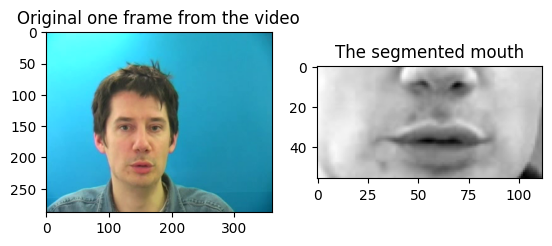

In [14]:
_, ax = plt.subplots(1, 2)
ax[0].imshow(sample[0][0][25].numpy().astype(np.uint8))
ax[0].set_title('Original one frame from the video')
ax[1].imshow(out[0][25].numpy(), cmap='gray')
ax[1].set_title('The segmented mouth')

# Res-Net block layer

In [15]:
class ResnetBlock(tf.keras.layers.Layer):
    def __init__(self, filters, down_sample=True, **kwargs):
        super(ResnetBlock, self).__init__(**kwargs)
        self.__filters = filters
        self.__down_sample = down_sample
        self.__kernel_size = (3, 3, 3)
        self.__strides = [(1, 2, 2), (1, 1, 1)] if down_sample else [(1, 1, 1), (1, 1, 1)]
        self.__kernel_initializer = "he_normal"

        self.identity_layers_names = []
        self.block_layers_names = []

        self.conv_1 = layers.Conv3D(
            filters=self.__filters, kernel_size=self.__kernel_size,
            strides=self.__strides[0], padding='same',
            kernel_initializer=self.__kernel_initializer
        )
        self.bn_1 = layers.BatchNormalization()
        self.act_1 = layers.Activation(
            activation='relu'
        )
        self.block_layers_names += [
            'conv_1', 'bn_1', 'act_1'
        ]

        self.conv_2 = layers.Conv3D(
            filters=self.__filters, kernel_size=self.__kernel_size,
            strides=self.__strides[1], padding='same',
            kernel_initializer=self.__kernel_initializer
        )
        self.bn_2 = layers.BatchNormalization()
        self.block_layers_names += [
            'conv_2', 'bn_2',
        ]

        self.marge = layers.Add()
        self.out = layers.Activation(
            activation='relu'
        )
        self.block_layers_names += [
            'marge', 'out',
        ]

        if self.__down_sample:
            self.identity_conv = layers.Conv3D(
                filters=self.__filters, kernel_size=(1, 1, 1),
                strides=self.__strides[0], padding='same',
                kernel_initializer=self.__kernel_initializer
            )
            self.identity_bn = layers.BatchNormalization()
            self.identity_layers_names += [
                'identity_conv', 'identity_bn'
            ]

    def call(self, x, training=False):
        identity = x
        for layer_name in self.identity_layers_names:
            identity = self.__getattribute__(layer_name)(identity)

        for layer_name in self.block_layers_names:
            if layer_name == 'marge':
                x = self.__getattribute__(layer_name)([identity, x])
                continue
            x = self.__getattribute__(layer_name)(x)

        return x

# Loss function - CTC (Connectionist Temporal Classification)

The CTC loss allows the model to learn to align input sequences of variable length with target sequences, even when there is no one-to-one correspondence between the input and target elements.

In [17]:
class CTCLoss(tf.keras.losses.Loss):
    def __init__(self):
        super(CTCLoss, self).__init__()
        self.loss_function = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_size = tf.cast(
            tf.shape(y_true)[0], dtype='int64'
        )
        input_size = tf.cast(
            tf.shape(y_pred)[1], dtype='int64'
        )
        input_size = input_size * tf.ones(
            shape=(batch_size, 1), dtype='int64'
        )

        label_size = tf.cast(
            tf.shape(y_true)[1], dtype='int64'
        )
        label_size = label_size * tf.ones(
            shape=(batch_size, 1), dtype='int64'
        )

        loss = self.loss_function(
            y_true=y_true, y_pred=y_pred, input_length=input_size, label_length=label_size
        )
        return loss

# Fuzzy Similarity function
In this model, the fuzzy similarity serves as an accuracy score for evaluating the model's performance during training.

It also determining when to perform early stopping.

In [18]:
class FuzzySimilarity(tf.keras.metrics.Metric):
    def __init__(self, name='FuzzySimilarity', **kwargs):
        super(FuzzySimilarity, self).__init__(name=name, **kwargs)
        self.total = self.add_weight(
            name="total", initializer="zeros"
        )
        self.count = self.add_weight(
            name="count", initializer="zeros"
        )

    @staticmethod
    def update_state_np(y_true, y_pred):
        decoded = tf.keras.backend.ctc_decode(
            y_pred, [y_pred.shape[1]] * y_pred.shape[0], greedy=False
        )[0][0].numpy()
        y_true_str = [
            tf.strings.reduce_join(num2char(y)).numpy().decode('utf-8') for y in y_true
        ]
        y_pred_str = [
            tf.strings.reduce_join(num2char(y)).numpy().decode('utf-8') for y in decoded
        ]
        sim = [
            fuzz.ratio(yt, yp) / 100 for yt, yp in zip(y_true_str, y_pred_str)
        ]
        return sum(sim) / 2

    def update_state(self, y_true, y_pred, sample_weight=None):
        sim = tf.py_function(
            self.update_state_np, [y_true, y_pred], tf.float32
        )
        self.total.assign_add(
            tf.cast(
                sim, self._dtype
            )
        )
        self.count.assign_add(
            tf.cast(
                1, self._dtype
            )
        )

    def result(self):
        return tf.math.divide(self.total, self.count)

# Model Callback
The model callback implements:

*   Learning rate schedule based on the Cosine Annealing with a linear warm-up.
*   Early stopping based on fuzzy similarity

In [19]:
class ModelCallback(tf.keras.callbacks.Callback):
    def __init__(self, learning_rate_base=0.01, warmup_learning_rate=1e-7, warmup_steps_practice=0.1,
                 global_step_init=0, fuzzy_patience=5):
        super(ModelCallback, self).__init__()
        self.learning_rate_base = learning_rate_base
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps_practice = warmup_steps_practice
        self.global_step = global_step_init
        self.total_steps = None
        self.warmup_steps = None
        self.slope = None
        self._built = False
        self.fuzzy_patience = fuzzy_patience
        self._best_fuzzy = 0
        self._fuzzy_patience_wait = 0

    def _build(self):
        self.total_steps = int(
            self.params['epochs'] * self.params['steps']
        )
        self.warmup_steps = int(
            self.total_steps * self.warmup_steps_practice
        )
        self.slope = (self.learning_rate_base - self.warmup_learning_rate) / self.warmup_steps
        self._built = True

    def on_batch_end(self, batch, logs=None):
        self.global_step = self.global_step + 1

    def on_batch_begin(self, batch, logs=None):
        if not self._built:
            self._build()

        if self.total_steps < self.warmup_steps:
            raise ValueError(
                'total_steps must be larger or equal to warmup_steps.'
            )
        if (self.warmup_steps > 0) and (self.learning_rate_base < self.warmup_learning_rate):
            raise ValueError(
                'learning_rate_base must be larger or equal to warmup_learning_rate.'
            )

        lr = 0.5 * self.learning_rate_base * (1 + np.cos(np.pi * (
                (self.global_step - self.warmup_steps) / (self.total_steps - self.warmup_steps)
        )))

        if self.warmup_steps > 0:
            warmup_rate = self.slope * self.global_step + self.warmup_learning_rate
            lr = np.where(
                self.global_step < self.warmup_steps, warmup_rate, lr
            )
        lr = np.where(
            self.global_step > self.total_steps, 0.0, lr
        )
        tf.keras.backend.set_value(
            self.model.optimizer.lr, lr
        )

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = float(
            tf.keras.backend.get_value(self.model.optimizer.lr)
        )
        if logs.get('FuzzySimilarity') is not None:
            fz = logs['FuzzySimilarity']
            self._fuzzy_patience_wait += 1
            if fz > self._best_fuzzy:
                self._best_fuzzy = fz
                self._fuzzy_patience_wait = 0
            if self._fuzzy_patience_wait >= self.fuzzy_patience:
                self.model.stop_training = True


# The Model

In [20]:
class LipsReadModel(tf.keras.models.Model):
    def __init__(self, input_shape, res_net_layers=10, **kwargs):
        super(LipsReadModel, self).__init__(**kwargs)
        self.input_layer = Input(shape=input_shape, name='Input')
        self.layers_names = []

        self.preprocessing = PreprocessingLayer(
            height=56, width=112, name='preprocessing'
        )

        self.conv = layers.Conv3D(
            filters=64, kernel_size=(1, 7, 7), padding='same', strides=(1, 1, 2),
            kernel_initializer="he_normal", name='conv'
        )
        self.bn = layers.BatchNormalization(name='bn')
        self.max_pool = layers.MaxPool3D(
            pool_size=(1, 3, 3), padding='same', strides=(1, 1, 1), name='max_pool'
        )
        self.layers_names += [
            'preprocessing', 'conv', 'bn', 'max_pool'
        ]
        down_sample_cond = [False] if res_net_layers == 10 else [False, False]

        for block_n, filters in enumerate([64, 128, 256, 512]):

            for i, sample in enumerate(down_sample_cond):
                name = f'block{block_n + 1}_{i + 1}'
                self.__setattr__(
                    name,
                    ResnetBlock(
                        filters=filters, down_sample=sample, name=name
                    )
                )
                self.layers_names += [name]
            down_sample_cond[0] = True

        self.avg = layers.AveragePooling3D(
            pool_size=(1, 7, 7), padding='same', name='avg'
        )
        self.flatten = layers.TimeDistributed(
            layers.Flatten(), name='flatten'
        )
        self.layers_names += [
            'avg', 'flatten'
        ]

        for i in range(2):
            names = [f'lstm_{i + 1}', f'drop_{i + 1}']
            self.__setattr__(
                names[0],
                layers.Bidirectional(
                    layers.LSTM(
                        128, kernel_initializer='Orthogonal', return_sequences=True
                    ), name=names[0]
                )
            )
            self.__setattr__(
                names[1],
                layers.Dropout(
                    0.5, name=names[1]
                )
            )
            self.layers_names += names

        self.dense = layers.Dense(
            char2num.vocabulary_size() + 1, kernel_initializer='he_normal',
            activation='softmax', name='dense'
        )

        self.layers_names += [
            'dense'
        ]

        self.output_layer = self.call(self.input_layer)

        super(LipsReadModel, self).__init__(
            inputs=self.input_layer,
            outputs=self.output_layer
        )

    def call(self, x, training=False):
        for layer_name in self.layers_names:
            x = self.__getattribute__(layer_name)(x)
        return x

# **Model set up**

---



In [21]:

data = createPipeline()
validation_size = int(0.1 * len(data))
test_size = int(0.1 * len(data))

test = data.take(test_size + validation_size)
validation = test.take(validation_size)
test = test.skip(validation_size)
train = data.skip(test_size + validation_size)

input_shape = data.as_numpy_iterator().next()[0][0].shape
model = LipsReadModel(input_shape)
model.summary()

model.compile(
    optimizer=Adam(learning_rate=1e-7), loss=CTCLoss(),
    metrics=[FuzzySimilarity()]
)

checkpoint_callback = ModelCheckpoint(
    os.path.join('/content', 'data', 'models', 'checkpoint'),
    monitor='loss', save_weights_only=True
)


Model: "lips_read_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 75, 288, 360, 3)  0         
                             ]                                   
                                                                 
 preprocessing (Preprocessin  (None, 75, 56, 112, 1)   0         
 gLayer)                                                         
                                                                 
 conv (Conv3D)               (None, 75, 56, 56, 64)    3200      
                                                                 
 bn (BatchNormalization)     (None, 75, 56, 56, 64)    256       
                                                                 
 max_pool (MaxPooling3D)     (None, 75, 56, 56, 64)    0         
                                                                 
 block1_1 (ResnetBlock)      (None, 75, 56, 56, 6

In [ ]:
model.fit(
    train, validation_data=validation, epochs=100,
    callbacks=[checkpoint_callback, ModelCallback()]
)

# Reference

[1] https://github.com/nicknochnack/LipNet/blob/main/LipNet.ipynb

[2] https://arxiv.org/abs/1611.01599